In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy

In [17]:
def make_env(depth, cost, ground_truth):
    reward = Categorical([-1, 1])
    env = MouselabEnv(2, depth, reward=reward, cost=cost)
    if ground_truth:
        env.ground_truth = np.array([0, *reward.sample(len(env.tree) - 1)])
    return env

def make_envs(depth=3, cost=.1, seed=0, n=100, ground_truth=False):
    np.random.seed(seed)
    if ground_truth:
        return [make_env(depth, cost, True) for _ in range(n)]
    else:
        return [make_env(depth, cost, False)] * n

In [18]:
agent = Agent()
def run_env(policy, env):
    agent.register(policy)
    agent.register(env)
    tr = agent.run_episode()
    return {'util': tr['return'],
            'observations': len(tr['actions']) - 1}

def evaluate(policy, envs):
    return pd.DataFrame(run_env(policy, env) for env in envs)

In [19]:
import time
def timed(method):

    def dec(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        print('%r %2.2f sec' % (method.__name__, te-ts))
        return result

    return dec

In [20]:
from policies import MouselabPolicy
from skopt import gp_minimize

@timed
def bo_policy(envs, n_calls=60, verbose=False):
    bounds = [ (-100., 100.) ] * 3
    def objective(theta):
        # theta = np.array(theta)
        a, b, c = theta
        theta = np.array([1, a, b, c, 1])
        util = evaluate(MouselabPolicy(theta), envs).util.mean()
        if verbose:
            print(theta.round(3), util)
        # regularize = 0.01 * (theta ** 2).sum()
        regularize = 0
        return - (util - regularize)
    
    result = gp_minimize(objective, bounds, n_calls=n_calls, random_state=0)
    a, b, c = result.x
    return MouselabPolicy(np.array([1, a, b, c, 1]))

In [21]:
from policies import MouselabPolicy
from skopt import gp_minimize

@timed
def alt_bo_policy(envs, n_calls=60, verbose=False):
    bounds = [ (0., 1.) ]
    def objective(theta):
        # theta = np.array(theta)
        w = theta[0]
        theta = np.array([1, 1-w, 0, w, 1])
        util = evaluate(MouselabPolicy(theta), envs).util.mean()
        if verbose:
            print(theta.round(3), util)
        # regularize = 0.01 * (theta ** 2).sum()
        regularize = 0
        return - (util - regularize)
    
    result = gp_minimize(objective, bounds, n_calls=n_calls, random_state=0)
    w = result.x[0]
    return MouselabPolicy(np.array([1, 1-w, 0, w, 1]))

In [22]:
from exact import solve
from policies import FunctionPolicy
@timed
def optimal_policy(env):
    Q, V, pi, info = solve(env, hash_state='sort_tree')
    policy = FunctionPolicy(pi)
    return policy, V(env.init)

In [23]:
def data():
    def dfs():
        for cost in np.logspace(-7, 0, 8, base=2):
            print('cost', cost)
            train_envs = make_envs(depth=3, cost=cost, n=200)
            term = train_envs[0].term_action
            opt_policy, opt_util = optimal_policy(train_envs[0])
            policies = {
                'BO_alt': alt_bo_policy(train_envs, n_calls=40),
                # 'myopic': MouselabPolicy([1, 1, 0, 0, 1]),
                # 'optimal': opt_policy,
                # 'full': FixedPlanPolicy(range(1, term+1)),
                # 'none': FixedPlanPolicy([term]),
                # 'one': FixedPlanPolicy([1, 5, 9, 13, TERM]),
                # 'two': FixedPlanPolicy([1, 2, 5, 6, 9, 10, 13, 14, TERM]),
            }
            eval_envs = make_envs(depth=3, cost=cost, n=500)
            for name, policy in policies.items():
                df = evaluate(policy, envs=eval_envs)
                df['agent'] = name
                df['cost'] = cost
                # print('======= {} ======='.format(name))
                # print('Observations: {:.3f}'.format(df.observations.mean() - 2))
                # print('Return: {:.3f}'.format(df.util.mean() / sigma))
                yield df
            yield pd.DataFrame([{'cost': cost, 'agent': 'exact_optimal', 'util': opt_util}])
    return pd.concat(dfs())

df = data()
# sns.factorplot('cost', 'util', hue='agent', data=df)

cost 0.0078125
'optimal_policy' 78.30 sec
'alt_bo_policy' 39.45 sec
cost 0.015625
'optimal_policy' 75.05 sec
'alt_bo_policy' 30.34 sec
cost 0.03125
'optimal_policy' 75.52 sec
'alt_bo_policy' 29.13 sec
cost 0.0625
'optimal_policy' 75.27 sec
'alt_bo_policy' 28.89 sec
cost 0.125
'optimal_policy' 76.30 sec
'alt_bo_policy' 25.23 sec
cost 0.25
'optimal_policy' 75.23 sec
'alt_bo_policy' 22.73 sec
cost 0.5
'optimal_policy' 75.08 sec
'alt_bo_policy' 24.54 sec
cost 1.0
'optimal_policy' 72.97 sec
'alt_bo_policy' 15.34 sec


(-2, 2)

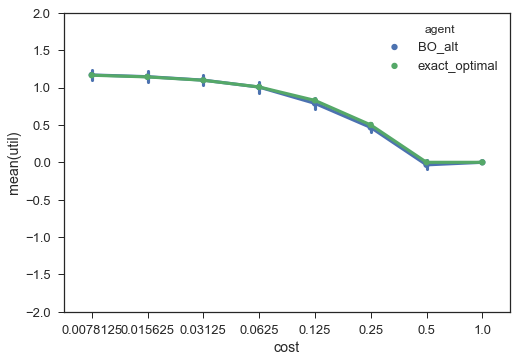

In [16]:
sns.set_style('ticks')
sns.pointplot('cost', 'util', hue='agent', data=df, markers='.', size=(4,4), )
plt.ylim(-2, 2)

# Regression

In [255]:
from collections import defaultdict
from toolz import memoize

def hash_key(args, kwargs):
    s = args[0]
    if s is None:
        return s
    else:
        return sort_tree(env, s)
    
def regression_data(env):
    Q, V, pi, info = solve(env, hash_state='sort_tree')
    data = []
    @memoize(key=hash_key)
    def rec(s):
        for a in env.actions(s):
            for p, s1, r in env.results(s, a):
                data.append({
                    'features': env.action_features(a, state=s),
                    'state': s,
                    'action': a,
                    'q_star': Q(s, a)
                })
                rec(s1)
    rec(env.init)
    return data

env = make_env(3, 0.2, None)
df = pd.DataFrame(regression_data(env))
len(df)
    

1362357

In [254]:
from sklearn.linear_model import LinearRegression

def run_regression(df):
    X = np.stack(df.features)
    m = LinearRegression().fit(X, df.q_star)
    df['q_hat'] = m.predict(X)
    df['abs_error'] = np.abs(df['q_hat'] - df['q_star'])
    return m.coef_

In [256]:
run_regression(df)

array([ 1.041,  0.442,  0.038,  0.478,  1.002])

In [258]:
coef = np.array([ 1.041,  0.442,  0.038,  0.478,  1.002])
sum(coef[1:-1])

0.95799999999999996

In [253]:
features = [
    'cost',
    'myopic_voc',
    'vpi_action',
    'vpi',
    'expected_term_reward',
]

def data():
    for cost in np.logspace(-2.5, 0.5, 5):
        env = make_env(3, cost, None)
        df = pd.DataFrame(regression_data(env))
        yield [cost, *run_regression(df)]

coefs = pd.DataFrame(data())
coefs.columns = ['COST', *features]
coefs = coefs.set_index('COST')

KeyboardInterrupt: 

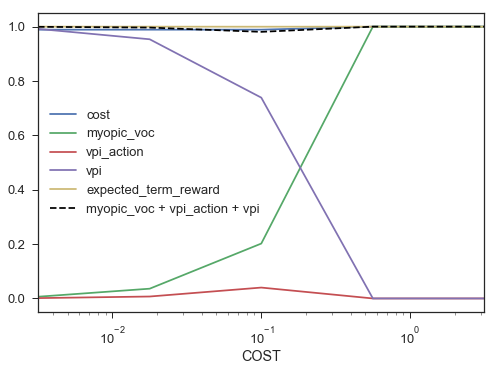

In [242]:
# coefs.myopic_voc + coefs.vpi

coefs.plot(logx=True)
plt.plot(coefs[['myopic_voc', 'vpi_action', 'vpi']].sum(axis=1), c='k', ls='--', 
         label='myopic_voc + vpi_action + vpi')
plt.legend()
# df.set_index('COST').plot()